In [11]:
from obs_models import *
from generate_data import *
from utils import *

%matplotlib inline

In [12]:
N, D = 1000,4
data = make_categorical_data(N,D)

[7 3 4 5]


In [13]:
data

tensor([[4., 0., 3., 3.],
        [1., 1., 2., 4.],
        [0., 0., 2., 1.],
        ...,
        [3., 1., 0., 0.],
        [0., 1., 0., 2.],
        [2., 2., 0., 2.]])

In [14]:
trace = pyro.poutine.trace(independentCategorical).get_trace(data)
#logp = trace.log_prob_sum()
#params = [trace.nodes[name]["value"].unconstrained() for name in trace.param_nodes]
#trace2 = pyro.poutine.trace(independentCategorical2).get_trace(data)

NameError: name 'D' is not defined

In [4]:
def independentCategoricalGuide(data):
    obs_dim, data_dim = data.shape
    # compute number of categories in each feature
    C = [np.unique(data[:,i]).shape[0] for i in range(D)]
    Cmax = np.max(C)
    C = torch.tensor(C)
    alphas = pyro.param('alphas', torch.ones(D,Cmax,dtype=torch.float64), constraint=constraints.positive)
    with pyro.plate('feature_plate', data_dim):
        pyro.sample('probs', pyro.distributions.Dirichlet(alphas))

In [5]:
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
elbo = Trace_ELBO(max_plate_nesting=2)
svi = SVI(independentCategorical, independentCategoricalGuide, optim, loss=elbo)

In [6]:
pyro.clear_param_store()

In [7]:
guide_trace = pyro.poutine.trace(independentCategoricalGuide).get_trace(data)

In [8]:
pyro.util.check_model_guide_match(trace, guide_trace)

NameError: name 'trace' is not defined

In [9]:
pyro.get_param_store().named_parameters()

dict_items([('alphas', tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64, requires_grad=True))])

In [23]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [24]:
def rel_err(true_parameter,estimated_parameter):
    if type(true_parameter) != torch.Tensor:
        true_parameter = torch.Tensor(true_parameter)
    norm = torch.norm
    return norm(true_parameter-estimated_parameter)/norm(true_parameter)

In [25]:
pyro.param('alphas')

tensor([[15.2690, 15.8122, 15.7969, 15.5664, 15.4220,  0.0534],
        [15.8758, 15.5346, 14.0170, 15.4700, 16.1497,  0.0443],
        [14.0860, 14.8840, 14.3809, 13.2279, 14.6049, 12.8324],
        [19.1577, 19.3151,  0.0365,  0.0373,  0.0382,  0.0380]],
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [26]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

NameError: name 'some_data_locs' is not defined

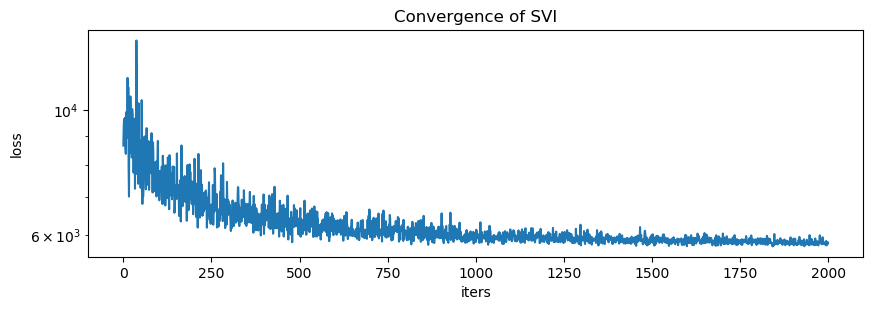

In [27]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

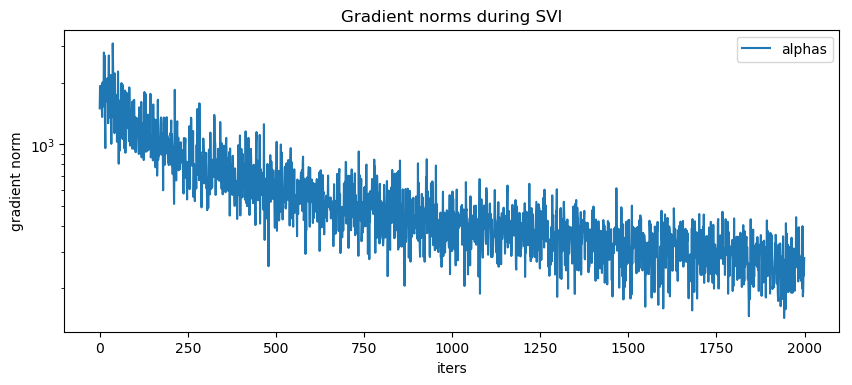

In [28]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [29]:
optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

NameError: name 'independentGaussian' is not defined

In [ ]:
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

In [ ]:
print(rel_err(some_data_locs,data.mean(0)))
print(rel_err(some_data_scales,np.sqrt(data.var(0))))